# Literature Review and Preliminary Exploratory Data Analysis

## Setup and Imports

In [1]:
%matplotlib inline

import os
import requests
import tqdm

import zipfile
import lzma
import json

import gzip
import csv

import pandas as pd

from matplotlib import pylab as plt
import seaborn as sns

from itertools import islice

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
import numpy as np

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data Description


> CAP includes all official, book-published United States case law — every volume designated as an official report of decisions by a court within the United States.
>
>Each volume has been converted into structured, case-level data broken out by majority and dissenting opinion, with >human-checked metadata for party names, docket number, citation, and date.
>
> -- <cite>[Case.law][1]</cite>

In the scope of this analysis we use the latest open case text from from bulk data exxports of open jurisdictions in the dataset. This subset consists of caselaws and metadata for the following four Jurisdictions:

1. ark - Arkansas
2. ill - Illinois
3. nc - North Carolina
4. nm - New Mexico

These were downloaded from [here][2].


**Citation Graph**

In addition to the case text we also use the case citation graph that links extracted, verified and unambiguous  citations to cases within the dataset. We use the citation graph from [2021-04-20][3] for this study. The citation graph is present in the form of a edgelist linking one case_id to multiple case_ids. It also contains all the references to all nodes from the case.law dataset. We truncate the graph based on case_ids we found in the case texts for each jurisdiction during preprocessing.

[1]: https://case.law/about/
[2]: https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/
[3]: https://case.law/download/citation_graph/2021-04-20/


In [2]:
##filename declarations

base_url = "https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/"
base_folder = "../data"
folder_names = ["ark", "ill", "nc", "nm"]
for item in folder_names:
    os.makedirs(f"{base_folder}/{item}", exist_ok=True)

def get_url_loc(file_name, base_url=base_url, base_folder=base_folder):
    url = os.path.join(base_url, file_name)
    file_loc = os.path.join(base_folder, file_name)
    return url, file_loc    
    
    
text_file_names = [f"{item}/{item}_text.zip" for item in folder_names]
xml_file_names = [f"{item}/{item}_xml.zip" for item in folder_names]

text_file_url_locs = list(map(get_url_loc, text_file_names))
xml_file_url_locs = list(map(get_url_loc, xml_file_names))

** downloads **

The following code downloads the raw dataset. 

NB: This is a onetime activity.


```{bash}
# download  citation graph and metadata
!wget -c https://case.law/download/citation_graph/2021-04-20/citations.csv.gz -P ../data/
!wget -c https://case.law/download/citation_graph/2021-04-20/metadata.csv.gz -P ../data/
```


```{python}
for url, file_name in tqdm.tqdm_notebook(text_file_url_locs, total=len(text_file_names)):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, "wb") as outfile:
            for chunk in response.iter_content(chunk_size=128):
                outfile.write(chunk)
                
for url, file_name in tqdm.tqdm_notebook(xml_file_url_locs, total=len(xml_file_names)):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, "wb") as outfile:
            for chunk in response.iter_content(chunk_size=128):
                outfile.write(chunk)
```

## Data Loading and Clean-up

In [3]:
def load_cases(fnames, field="id"):
    cases = []
    for fname in fnames:
        with zipfile.ZipFile(fname, 'r') as zip_archive:
            xz_path = next(path for path in zip_archive.namelist() if path.endswith('/data.jsonl.xz'))
            with zip_archive.open(xz_path) as xz_archive, lzma.open(xz_archive) as jsonlines:
                for i, line in tqdm.tqdm_notebook(enumerate(jsonlines)):
                    record = json.loads(str(line, 'utf-8'))
                    if field:
                        record = {field: record[field]}
                    cases.append(record)
        print(f"loaded {i+1} cases from {fname.split('/')[-1]}")
    return pd.DataFrame(cases)

def read_citation_graph(fname, case_ids):
    csvobj = csv.reader(gzip.open(fname, mode='rt'),delimiter = ',',quotechar="'")
    graph = []
    for item in tqdm.tqdm_notebook(csvobj):
        head = item[0]
        try:
            head = int(head)
        except ValueError:
            head = None
        if head in case_ids:
            graph.append(item)
    citation_graph = pd.DataFrame(graph)
    citation_graph = citation_graph.set_index(0)
    citation_graph = citation_graph.apply(lambda x: x.dropna().tolist(), axis=1)
    return citation_graph


def read_citiation_metadata(fname, case_ids):
    csvobj = csv.DictReader(gzip.open(fname, mode='rt'),delimiter = ',')
    graph_meta = []
    for item in tqdm.tqdm_notebook(csvobj):
        head = item["id"]
        try:
            head = int(head)
        except ValueError:
            head = None
        if head in case_ids:
            graph_meta.append(item)
    graph_meta = pd.DataFrame(graph_meta).set_index("id")
    return graph_meta

In [4]:
_, text_fnames= zip(*text_file_url_locs)
cases_data = load_cases(text_fnames, field=None)

<ipython-input-3-4b5d67d4d59d>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, line in tqdm.tqdm_notebook(enumerate(jsonlines)):


0it [00:00, ?it/s]

loaded 59735 cases from ark_text.zip


0it [00:00, ?it/s]

loaded 183033 cases from ill_text.zip


0it [00:00, ?it/s]

loaded 97600 cases from nc_text.zip


0it [00:00, ?it/s]

loaded 18338 cases from nm_text.zip


In [5]:
print(f"Total number of cases in the raw dataset : {len(cases_data)}")
print(f"Total number of columns in the raw dataset : {len(cases_data.columns)}")

Total number of cases in the raw dataset : 358706
Total number of columns in the raw dataset : 17


In [6]:
##view the first case
sample_case = cases_data.iloc[0,:].to_json()
#fix for escape chars
sample_case = json.dumps(json.loads(sample_case), indent=2)
print(sample_case)

{
  "id": 1869772,
  "url": "https://api.capapi.org/v1/cases/1869772/",
  "name": "James Joseph STANDLEY, Jr. v. STATE of Arkansas",
  "name_abbreviation": "Standley v. State",
  "decision_date": "1987-11-09",
  "docket_number": "",
  "first_page": "517",
  "last_page": "518",
  "citations": [
    {
      "cite": "293 Ark. 517",
      "type": "official"
    },
    {
      "cite": "738 S.W.2d 423",
      "type": "parallel"
    }
  ],
  "volume": {
    "volume_number": "293",
    "barcode": "32044078577145",
    "url": "https://api.capapi.org/v1/volumes/32044078577145/"
  },
  "reporter": {
    "id": 368,
    "full_name": "Arkansas Reports",
    "url": "https://api.capapi.org/v1/reporters/368/"
  },
  "court": {
    "name_abbreviation": "Ark.",
    "name": "Arkansas Supreme Court",
    "id": 8808,
    "slug": "ark",
    "url": "https://api.capapi.org/v1/courts/ark/"
  },
  "jurisdiction": {
    "name": "Ark.",
    "id": 34,
    "slug": "ark",
    "name_long": "Arkansas",
    "url": "http

In [7]:
#get columns with any empty values
display(cases_data.applymap(lambda x: True if x else False).all(axis=0))

id                    True
url                   True
name                  True
name_abbreviation     True
decision_date         True
docket_number        False
first_page            True
last_page             True
citations             True
volume                True
reporter              True
court                 True
jurisdiction          True
cites_to             False
frontend_url          True
preview              False
casebody              True
dtype: bool

In [8]:
# initally looks like `preview` and `docket_number` are sparse and don't really matter for the problem.
# we'll get the citation information after linking the citation graph
drop_cols = ["docket_number", "preview","cites_to", "citations"]
cases_data = cases_data.drop(drop_cols, axis=1)

In [9]:
# convert the id to int for indexing
cases_data["id"] = cases_data["id"].astype(int)
cases_data = cases_data.set_index("id")

In [10]:
# convert date column
display(cases_data[cases_data.decision_date == "1914-02-29"])
cases_data["decision_date"] = pd.to_datetime(cases_data["decision_date"], format="%Y-%m-%d", errors="coerce")
cases_data = cases_data[cases_data["decision_date"].notnull()]

,url,name,name_abbreviation,decision_date,first_page,last_page,volume,reporter,court,jurisdiction,frontend_url,casebody
id,,,,,,,,,,,,
11269973,https://api.capapi.org/v1/cases/11269973/,STATE v. LESTER MORRIS,State v. Morris,1914-02-29,441,441,"{'volume_number': '166', 'barcode': '320440578...","{'id': 549, 'full_name': 'North Carolina Repor...","{'name_abbreviation': 'N.C.', 'name': 'Supreme...","{'name': 'N.C.', 'id': 5, 'slug': 'nc', 'name_...",https://cite.capapi.org/nc/166/441/,"{'status': 'ok', 'data': {'judges': [], 'head_..."


In [11]:
## extract and normalize volumes
volumes_data = pd.DataFrame(cases_data.volume.tolist(), index=cases_data.index)
volumes_data.loc[:, "volume_number"] = volumes_data["volume_number"].astype(int)
cases_data.loc[:, "volume_id"] = volumes_data["volume_number"]
volumes_data = volumes_data.drop_duplicates("volume_number")

In [12]:
# volumes_data.to_csv("data/subset/volumes.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [13]:
# extract and normalize reporters
reporters_data = pd.DataFrame(cases_data["reporter"].tolist(), index=cases_data.index)
reporters_data.loc[:, "id"] = reporters_data["id"].astype(int)
cases_data.loc[:, "reporter_id"] = reporters_data["id"]
reporters_data = reporters_data.drop_duplicates("id")

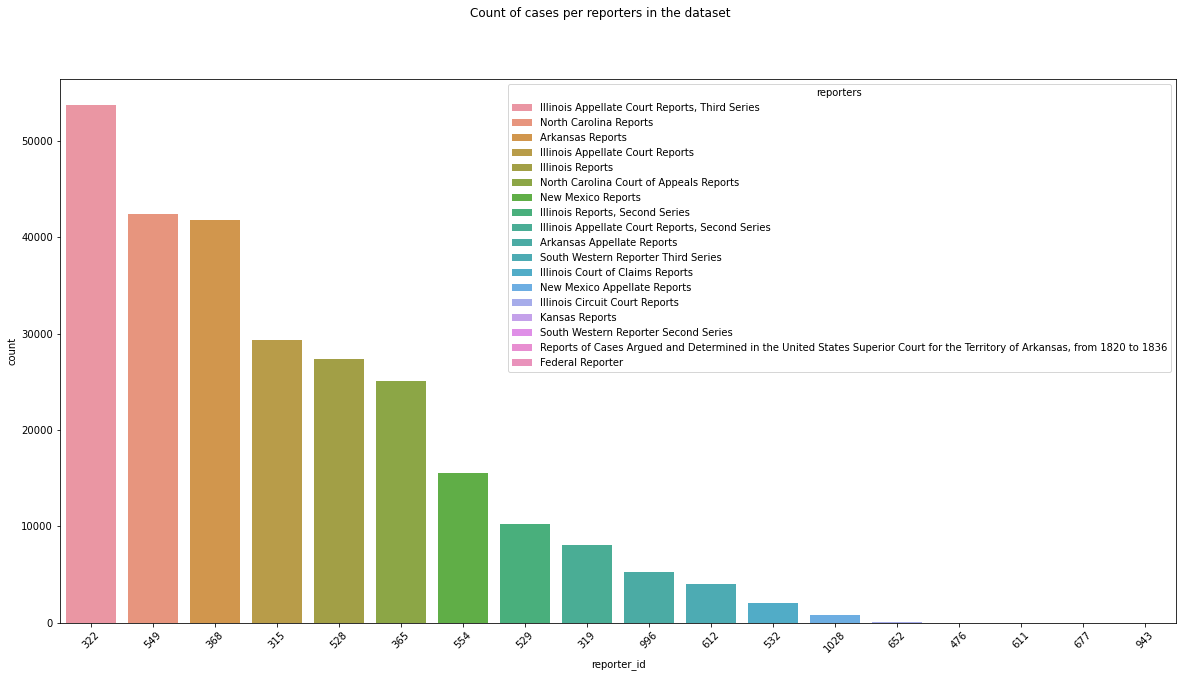

In [54]:
cases_by_reporters = cases_data.reporter_id.value_counts()
reporter_names = reporters_data.set_index("id").loc[cases_by_reporters.index, "full_name"].tolist()
cases_by_reporters = cases_by_reporters.reset_index()
cases_by_reporters['reporters']  = reporter_names
cases_by_reporters = cases_by_reporters.rename({"reporter_id": "count", "index": "reporter_id"}, axis=1)
cases_by_reporters["reporter_id"] = cases_by_reporters["reporter_id"].map(str)
plt.figure(figsize=(20,10))
sns.barplot(data = cases_by_reporters,x="reporter_id", y="count", hue="reporters", dodge=False)
plt.xticks(None, rotation=45)
plt.suptitle("Count of cases per reporters in the dataset")
plt.show()

In [30]:
# reporters_data.to_csv("data/subset/reporters.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [31]:
# extract and normalize courts
courts_data = pd.DataFrame(cases_data["court"].tolist(), index=cases_data.index)
courts_data.loc[:, "id"] = courts_data["id"].astype(int)
cases_data.loc[:, "court_id"] = courts_data["id"]
courts_data = courts_data.drop_duplicates("id")

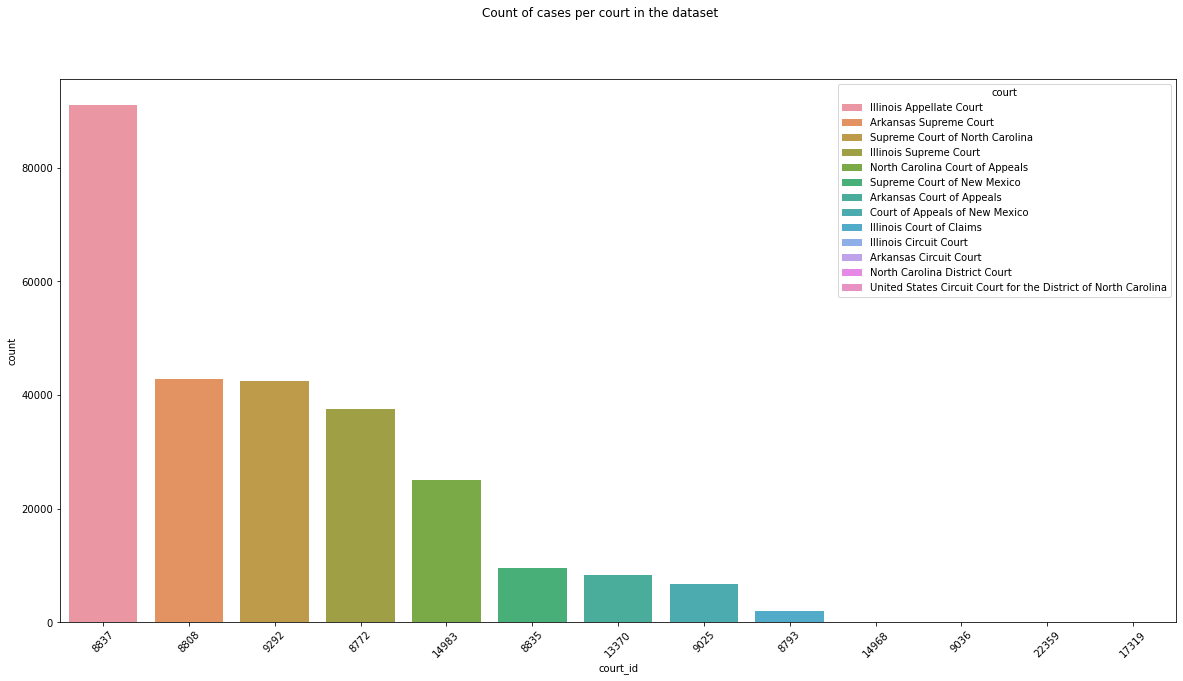

In [57]:
cases_by_courts = cases_data.court_id.value_counts()
court_names = courts_data.set_index("id").loc[cases_by_courts.index, "name"].tolist()

cases_by_courts = cases_by_courts.reset_index()
cases_by_courts['court']  = court_names
cases_by_courts = cases_by_courts.rename({"court_id": "count", "index": "court_id"}, axis=1)
cases_by_courts["court_id"] = cases_by_courts["court_id"].map(str)
plt.figure(figsize=(20,10))
sns.barplot(data = cases_by_courts,x="court_id", y="count", hue="court", dodge=False)


plt.suptitle("Count of cases per court in the dataset")
plt.xticks(rotation=45)
plt.show()

In [35]:
# courts_data.to_csv("data/subset/courts.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [36]:
# extract and normalize jurisdictions
jurisdictions_data = pd.DataFrame(cases_data["jurisdiction"].tolist(), index=cases_data.index)
jurisdictions_data.loc[:,"id"] = jurisdictions_data["id"].astype(int)
cases_data.loc[:, "jurisdiction_id"] = jurisdictions_data["id"]
jurisdictions_data = jurisdictions_data.drop_duplicates("id")

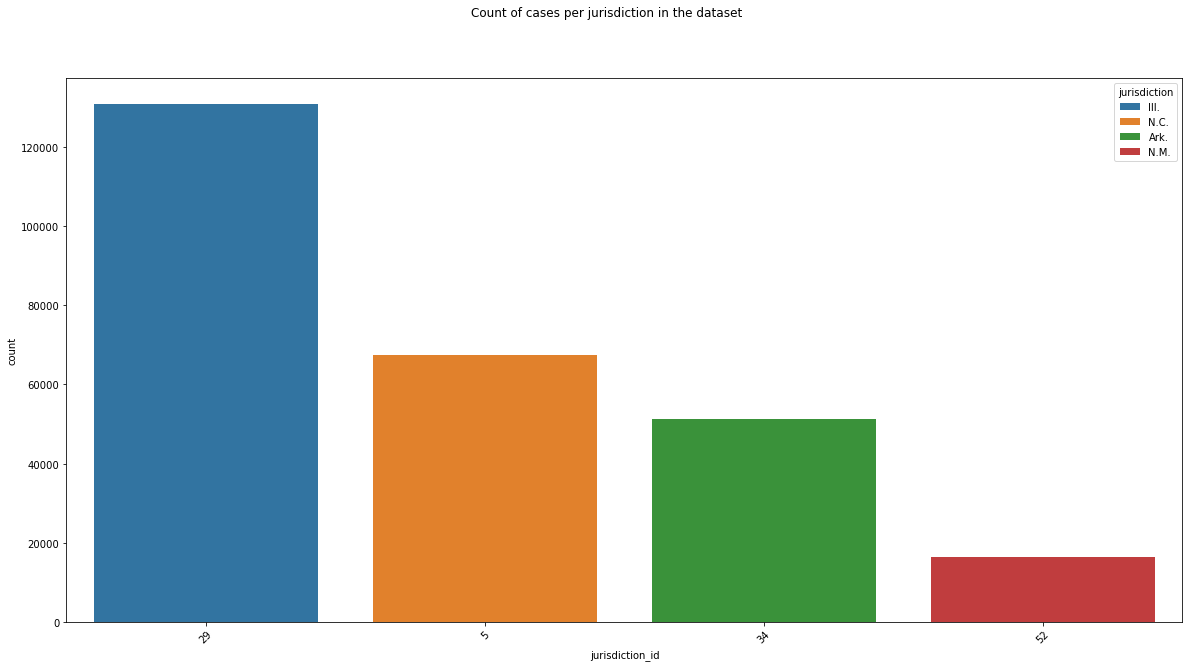

In [58]:
cases_by_jurisdictions = cases_data.jurisdiction_id.value_counts()
jurisdiction_names = jurisdictions_data.set_index("id").loc[cases_by_jurisdictions.index, "name"].tolist()

cases_by_jurisdictions = cases_by_jurisdictions.reset_index()
cases_by_jurisdictions['jurisdiction']  = jurisdiction_names
cases_by_jurisdictions = cases_by_jurisdictions.rename({"jurisdiction_id": "count", "index": "jurisdiction_id"}, axis=1)
cases_by_jurisdictions["jurisdiction_id"] = cases_by_jurisdictions["jurisdiction_id"].map(str)
plt.figure(figsize=(20,10))
sns.barplot(data = cases_by_jurisdictions,x="jurisdiction_id", y="count", hue="jurisdiction", dodge=False)


plt.suptitle("Count of cases per jurisdiction in the dataset")
plt.xticks(rotation=45)
plt.show()

In [38]:
# jurisdictions_data.to_csv("data/subset/jurisdictions.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [39]:
# extract case opinion and headmatter
casebody_data = pd.DataFrame(cases_data.loc[:, "casebody"].map(lambda x: x.get("data")).tolist(), index=cases_data.index)
cases_data.loc[: , "head_matter"] = casebody_data.loc[:, "head_matter"]
cases_data.loc[: , "opinion_text"] = casebody_data.loc[:,"opinions"].map(lambda x: "\n".join(y.get("text", "") for y in x))
cases_data["head_matter"] = cases_data["head_matter"]
cases_data["opinion_text"] = cases_data["opinion_text"]

/Users/bebop/anaconda3/envs/cs109b-grp9-final-project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


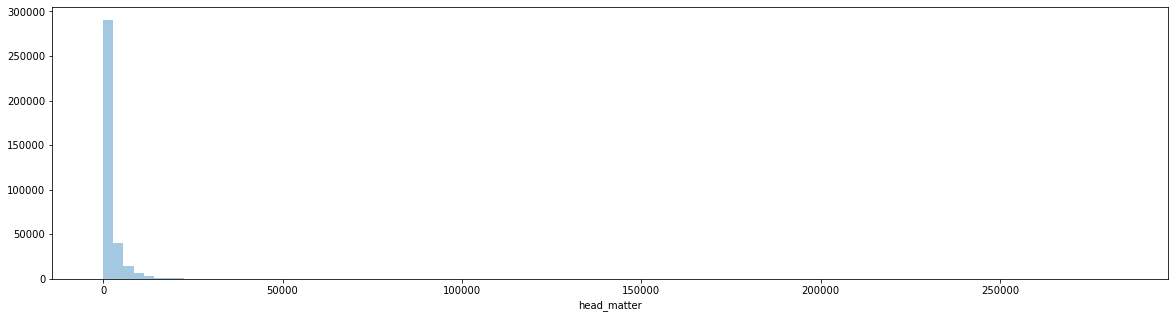

In [40]:
plt.figure(figsize=(20, 5))
sns.distplot(cases_data.head_matter.map(len), bins=100, kde=False)
plt.show()

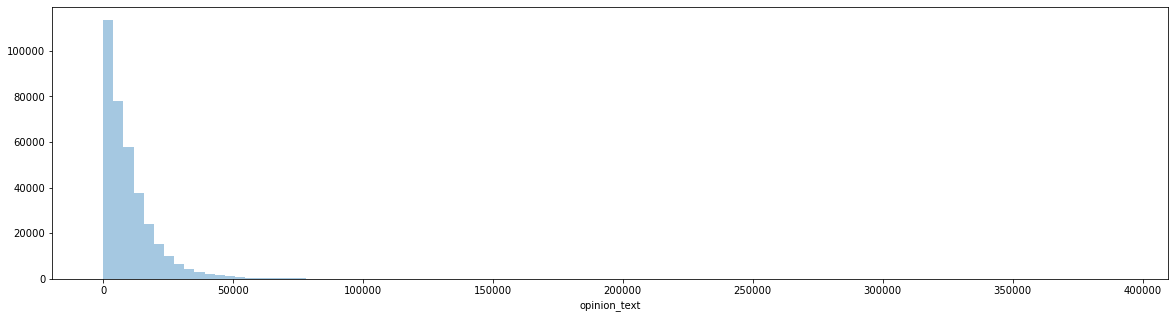

In [41]:
plt.figure(figsize=(20, 5))
sns.distplot(cases_data.opinion_text.map(len), bins=100, kde=False)
plt.show()

In [42]:
#read citation graph and link nodes
citation_graph = read_citation_graph("../data/citations.csv.gz", case_ids=frozenset(cases_data.index))
print(f"found and loaded {len(citation_graph)} nodes into citation_graph")

#create a lookup for our cases
citations_uids = frozenset(citation_graph.index)

# remove citations that aren't in case data
citation_graph = citation_graph.loc[:].map(lambda x: list(filter(lambda y: y in citations_uids, x)))

# remove cases with no citations after truncation
citation_graph = citation_graph[citation_graph.map(len) > 0]
citation_graph.index = citation_graph.index.astype(int)

cases_data.loc[citation_graph.index, "citation_ids"] = citation_graph.values
cases_data = cases_data[cases_data.citation_ids.notnull()]


<ipython-input-3-4b5d67d4d59d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm.tqdm_notebook(csvobj):


0it [00:00, ?it/s]

found and loaded 278778 nodes into citation_graph


In [ ]:
required_case_cols = [
    'decision_date', 'name', 'name_abbreviation',
    'frontend_url', 'url', 
    #'head_matter', 'opinion_text', 
    'volume_id', 'reporter_id', 'court_id', 'jurisdiction_id',]
#     'citation_ids']
# cases_data[required_case_cols].reset_index().to_csv("data/subset/cases.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')


In [ ]:
citations_data = cases_data["citation_ids"].explode().reset_index()
citations_data.columns = ["src", "dst"]
# citations_data.to_csv("data/subset/citations.csv", index=False, index_label=False,)


In [ ]:
# citations_data = pd.read_csv("../data/subset/citations.csv")

In [ ]:
top_cited = citations_data.src.value_counts().head(50)
plt.figure(figsize=(20,10))
ax = sns.barplot(top_cited.index, top_cited.values, order=top_cited.index)
plt.xticks(rotation=45)
plt.show()

In [ ]:
citations_data.groupby("src").count

In [ ]:
cases_data.groupby(["court_id", "jurisdiction_id"]).agg({"citation_ids": sum})

In [ ]:
len(cases_data)

## Text Data Analysis

**Preprocessing**

As we saw the case texts are quite large. Additionally the we see hints from reviewing a few sample cases that there are mentions of person names, organizations and other entities such as dates in the case data. First we concatenate the case text (Head matter and Opinions) into a single field and proceed to preprocess the text.

First we parse the text using spacy and retain only words that are tagged as `Adjectives`, `Adverbs`, `Nouns`, `Proper Nouns` and `Pronouns`. This reduces the dimensionality of the data by a large factor and makes it feasiable to work with the text

In [ ]:
class CaselineIterator:
    def __init__(self, fname, slice_size=None):
        self.fname = fname
        self.slice_size=slice_size
        self._length = slice_size
    def __iter__(self):
        if self.slice_size:
            iterator = islice(open(self.fname), self.slice_size)
        else:
            iterator = open(self.fname)
        for line in iterator:
            yield line.split()
            
    def __len__(self):
        if not self._length:
            self._length = sum(1 for _ in open(self.fname))
        return self._length


In [ ]:
class CaselawCorpus():
    def __init__(self, iterator, dictionary, **kwargs):
        self.iterator = iterator
        self.dictionary = dictionary
        
    def __iter__(self):
        for line in self.iterator:
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(line)
    def __len__(self):
        return len(self.iterator)

In [ ]:
# https://stackoverflow.com/a/52304675
def top_n_idx_sparse(matrix, n):
    '''Return index of top n values in each row of a sparse matrix'''
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        top_n_idx.append(matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]])
    return top_n_idx

In [ ]:
class BaselineModel:
    def __init__(self, no_below=5, no_above=0.75):
        self.dictionary = None
        self.corpus = None
        self.model = None
        self.index = None
        self.no_below=no_below
        self.no_above=no_above
    
    def fit(self, texts, **kwargs):
        self.dictionary = Dictionary(texts)
        self.dictionary.filter_extremes(self.no_below, self.no_above)
        self.dictionary.compactify()
        
        self.corpus = CaselawCorpus(texts, self.dictionary,**kwargs)
        self.model = TfidfModel(self.corpus)
        self.index = SparseMatrixSimilarity(
            self.model[self.corpus], 
            num_features=len(self.dictionary),
            num_terms=len(self.dictionary),
            num_docs=len(self.corpus),
            maintain_sparsity=True)
        return self
    
    def predict(self, texts, top_k=5):
        pred_corpus = [self.dictionary.doc2bow(item) for item in texts]
        pred_vecs = self.model[pred_corpus]
        pred_sims = self.index[pred_vecs]
        return pred_sims

In [ ]:
case_lines = pd.read_csv("../data/subset/caselines.txt", header=None, names=["text"])
case_lines.index=cases_data.index

In [ ]:
baseline_model = BaselineModel()

In [ ]:
baseline_model.fit(case_lines.text.str.split())

In [ ]:
# idx2case_id = cases_data.reset_index()["id"]
# case2idx = pd.Series({v:k for k,v in idx2case_id.items()})

In [ ]:
preds = baseline_model.predict(case_lines.head()['text'].str.split())

In [ ]:
all_sims = []
for item in cases_data.citation_ids.map(lambda x: [int(y) for y in x]).head():
    mat_idxs = [case_lines.index.get_loc(i) for i in item]
    for idx, sim in zip(mat_idxs, preds.toarray()):
        mean_sim = sim[idx].mean()
        all_sims.append(mean_sim)
print(np.mean(all_sims))

In [ ]:
def citation_similarities(cases_data):
    for case_id, citation_ids in cases_data["citation_ids"].items():
        query_idx = case2idx[citations]
        citiation_idxs = case2idx[citation_ids]
        query_doc = texts[query_idx]
        citation_docs = texts[citation_docs]
        map(labda)

In [ ]:
pred_sims.toarray()

In [ ]:
preds = top_n_idx_sparse(pred_sims, top_k)
def precision_recall_k(y_true, y_pred):
    for y_t, y_p in zip(y_true, y_pred):
        relevant_retrieved = set(y_t).intersection(y_p)
        if relevant_retrieved:
            precision = len(relevant_retrieved)/len(y_p)
            recall = len(relevant_retrieved)/len(y_t)
            
        relevant_retrieved